<a href="https://colab.research.google.com/github/Daisuke-lab/segemnation-model/blob/main/segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maybe somthing wrong with Dataset, so follow the kaggle and create a model from scratch and find what is wrong

With     # mask = np.array(mask)  mask = mask[:, :, np.newaxis], resnetX50

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 128, 128, 1])) that is different to the input size (torch.Size([16, 1, 128, 128])) is deprecated. Please ensure they have the same size

1. resnext50_32x4dをそのままトライ。まずまずの結果
2. resnext50_32x4dにcatalystをつけて行う。lossはclassとなっているloss funcしかだめらしい。smp.utils.losses.DiceLoss()に変更して行う。
problem: AttributeError: 'bool' object has no attribute 'state_dict' => sheduler 必須
result:真っ黒。なんの結果もでない。
3.resnext50_32x4dにcatalystをつけて行う。loss をBCEDiceLossで調べてみる。
result:真っ黒。なんの結果もでない。

Conclusion:
This type of segmentation require its own loss fuction not existing ones. Therefore, it is not comptible with catalyst and you need to make every models from scratch


In [ ]:
pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-zt1t42gk
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-zt1t42gk
     |████████████████████████████████| 952kB 2.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=71852 sha256=d2a2eb764ce32d420af3b2445c3b5f1ecd732f083ab4f8a7d9da1d4f5e672a99
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ezvd2ve/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install segmentation_models_pytorch

In [ ]:
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import albumentations as A
import copy
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Kaggle/kaggle_3m/complete_csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
PATCH_SIZE = 128#256
transformation = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),                  
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # A.RandomBrightnessContrast(p=0.5),
    # A.RandomGamma(p=0.25),
    # A.IAAEmboss(p=0.25),
    # A.Blur(p=0.01, blur_limit = 3),
    
    # A.OneOf([
    #     A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #     A.GridDistortion(p=0.5),
    #     A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.8),
    
    A.Normalize(p=1.0),
    ToTensor()
])

In [ ]:
class CreateDataset(Dataset):
  def __init__(self,df, transforms=False, preprocessing=False):
    self.transforms = transforms
    self.df  = df
    self.preprocessing = preprocessing

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    image = cv2.imread(self.df.iloc[idx,1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(self.df.iloc[idx, 2], 0) 
    # mask = np.array(mask)
    # mask = mask[:, :, np.newaxis]

    if self.transforms:
      augmented = self.transforms(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask']


    if self.preprocessing:
      preprocessed = self.preprocessing(image=image, mask=mask)
      image = preprocessed['image']
      mask = preprocessed['mask']

      # mask[mask >= 0.5] = 1.0
    # mask = mask.squeeze(0)



    return image, mask

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [ ]:
#DATA
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# train
train_dataset = CreateDataset(df=train_df, transforms=transformation, )
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)

# val
val_dataset = CreateDataset(df=val_df, transforms=transformation, )
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4, shuffle=True)

#test
test_dataset = CreateDataset(df=test_df, transforms=transformation, )
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=True)

In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [ ]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [ ]:
#LOSS_FUNC

#this function is a part of bce_dice_loss
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore






def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

In [ ]:
rx50 = ResNeXtUNet(n_classes=1).to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)
num_ep = 10 
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50
Epoch [0]
Mean loss on train: 0.5454272784768267 
Mean DICE on train: 0.561180742017866 
Mean DICE on validation: 0.6091395423169516
Epoch [1]
Mean loss on train: 0.4408134530357858 
Mean DICE on train: 0.6416067852284106 
Mean DICE on validation: 0.646029289290901
Epoch [2]
Mean loss on train: 0.365361819440063 
Mean DICE on train: 0.7034180274991599 
Mean DICE on validation: 0.7091783830732808
Epoch [3]
Mean loss on train: 0.3433455539906913 
Mean DICE on train: 0.7196730539647167 
Mean DICE on validation: 0.6359911992845754
Epoch [4]
Mean loss on train: 0.3493992303042336 
Mean DICE on train: 0.7130254356805606 
Mean DICE on validation: 0.7412724113131489
Epoch [5]
Mean loss on train: 0.3725822846543916 
Mean DICE on train: 0.6944274510631508 
Mean DICE on validation: 0.6947092760291559
Epoch [6]
Mean loss on train: 0.3456539404677584 
Mean DICE on train: 0.7145965445882025 
Mean DICE on validation: 0.7820210255217654
Epoch [7]
Mean loss on train: 0.29520665184455985 
Mean

rx50_lh=[0.5454272784768267,
 0.4408134530357858,
 0.365361819440063,
 0.3433455539906913,
 0.3493992303042336,
 0.3725822846543916,
 0.3456539404677584,
 0.29520665184455985,
 0.290443988952865,
 0.29193144703799107]

rx50_th=[0.561180742017866,
 0.6416067852284106,
 0.7034180274991599,
 0.7196730539647167,
 0.7130254356805606,
 0.6944274510631508,
 0.7145965445882025,
 0.7560546983274414,
 0.7619427427093969,
 0.7591479987944734]

rx50_vh=[0.6091395423169516,
 0.646029289290901,
 0.7091783830732808,
 0.6359911992845754,
 0.7412724113131489,
 0.6947092760291559,
 0.7820210255217654,
 0.7359790833030839,
 0.7729043617336456,
 0.6740490187258005]

In [ ]:
import pickle
f = open('/content/drive/My Drive/rx50_lh.txt', 'wb')
pickle.dump(rx50_lh, f)

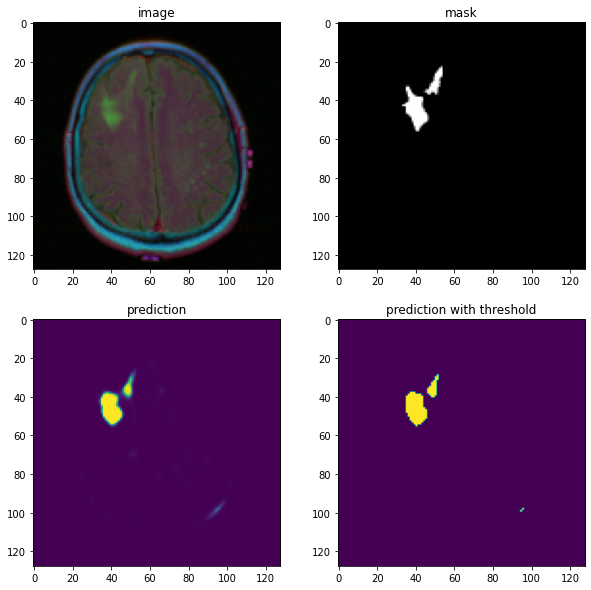

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()
#fig.savefig("/content/drive/My Drive/brain_rx50.jpg")

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()